<h2 id='part1'> Airbnb data analysis: Seattle vs. Boston </h2>

In this project we’ll use the Seattle airbnb listing from Seattle Airbnb Open Data
in Kaggle. To understand how much Airbnb homes are earning in certain time frames and areas
 we build a model of rates in the different areas, and compare with the dataset from Airbnb in Boston. We also compare rates between the two cities, and understand if there is anything about the properties that helps us to predict price. We investigate negative and positive reviews based on the text.

First we read the data and have look at the attributes for airbnb listing in Seattle.

In [22]:
# Import libraries
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [23]:
# Import Seattle dataset
seattle = pd.read_csv('./seattle_airbnb_dataset/listings.csv')
# Subset to only quantitative vars
seattle = seattle[['id', 'host_id', 'host_is_superhost','zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 'bedrooms', 'price', 'cleaning_fee', 'security_deposit','review_scores_value', 'reviews_per_month', 'review_scores_location', 'review_scores_communication', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_rating' , 'number_of_reviews']]
seattle.head()

,id,host_id,host_is_superhost,zipcode,latitude,longitude,property_type,room_type,bedrooms,price,...,security_deposit,review_scores_value,reviews_per_month,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews
0,241032,956883,f,98119,47.636289,-122.371025,Apartment,Entire home/apt,1.0,$85.00,...,NaN,10.0,4.07,9.0,10.0,10.0,10.0,10.0,95.0,207
1,953595,5177328,t,98119,47.639123,-122.365666,Apartment,Entire home/apt,1.0,$150.00,...,$100.00,10.0,1.48,10.0,10.0,10.0,10.0,10.0,96.0,43
2,3308979,16708587,f,98119,47.629724,-122.369483,House,Entire home/apt,5.0,$975.00,...,"$1,000.00",10.0,1.15,10.0,10.0,10.0,10.0,10.0,97.0,20
3,7421966,9851441,f,98119,47.638473,-122.369279,Apartment,Entire home/apt,0.0,$100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,278830,1452570,f,98119,47.632918,-122.372471,House,Entire home/apt,3.0,$450.00,...,$700.00,9.0,0.89,9.0,10.0,10.0,9.0,9.0,92.0,38


## Seattle Airbnb Open Data

### Context

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.  This data includes metrics such as the Neighbourhood, property type, number of guests to accommodate, number of bathrooms and bedrooms, cleaning fee, review score etc.

### Size
There are 3818 instances in the dataset. Some attributes have less than 3818 non-null values. We will need to take care of this later.

### Come up with three questions you are interested in answering.

1. What is the relationship between price and size of the property?
2. What is the district’s median rate in Seattle including the fees?
3. What features contributes mostly to the high reviews?
4. How well can we predict a superhost?

## Handling missing values

In [24]:
seattle.dropna(how='all', inplace=True)
seattle.dropna(subset=['review_scores_rating', 'price'], how='any', inplace=True)

str_cols = ['price', 'security_deposit', 'cleaning_fee']
for s in str_cols:
    try:
        seattle[s] = seattle[s].str.replace('$', '', regex=True)
        seattle[s] = seattle[s].str.replace(',', '', regex=True)
        seattle[s] = pd.to_numeric(seattle[s])
        seattle[s] = seattle[s].fillna(value=0)
    except:
        print("it didn't work!")

total_price = seattle['price'] + seattle['cleaning_fee']
seattle['total_price'] = total_price

seattle.head()

,id,host_id,host_is_superhost,zipcode,latitude,longitude,property_type,room_type,bedrooms,price,...,review_scores_value,reviews_per_month,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,total_price
0,241032,956883,f,98119,47.636289,-122.371025,Apartment,Entire home/apt,1.0,85.0,...,10.0,4.07,9.0,10.0,10.0,10.0,10.0,95.0,207,85.0
1,953595,5177328,t,98119,47.639123,-122.365666,Apartment,Entire home/apt,1.0,150.0,...,10.0,1.48,10.0,10.0,10.0,10.0,10.0,96.0,43,190.0
2,3308979,16708587,f,98119,47.629724,-122.369483,House,Entire home/apt,5.0,975.0,...,10.0,1.15,10.0,10.0,10.0,10.0,10.0,97.0,20,1275.0
4,278830,1452570,f,98119,47.632918,-122.372471,House,Entire home/apt,3.0,450.0,...,9.0,0.89,9.0,10.0,10.0,9.0,9.0,92.0,38,575.0
5,5956968,326758,f,98119,47.630525,-122.366174,House,Private room,1.0,120.0,...,10.0,2.45,10.0,10.0,10.0,10.0,10.0,95.0,17,160.0


In [25]:
seattle.describe()

,id,host_id,latitude,longitude,bedrooms,price,cleaning_fee,security_deposit,review_scores_value,reviews_per_month,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_rating,number_of_reviews,total_price
count,3.171000e+03,3.171000e+03,3171.000000,3171.000000,3165.000000,3171.000000,3171.000000,3171.000000,3162.000000,3171.000000,3163.000000,3167.000000,3160.000000,3165.000000,3160.000000,3171.000000,3171.000000,3171.000000
mean,5.017752e+06,1.437149e+07,47.628684,-122.332870,1.302686,126.802586,46.357616,141.853674,9.452245,2.089722,9.608916,9.809599,9.786709,9.556398,9.636392,94.539262,26.751498,173.160202
std,2.801376e+06,1.343307e+07,0.042962,0.031571,0.874565,90.007172,49.580513,234.643791,0.750259,1.822827,0.629053,0.568211,0.595499,0.797274,0.698031,6.606083,39.914223,125.799483
min,4.291000e+03,4.193000e+03,47.505088,-122.417219,0.000000,22.000000,0.000000,0.000000,2.000000,0.020000,4.000000,2.000000,2.000000,3.000000,2.000000,20.000000,1.000000,22.000000
25%,2.694596e+06,3.074414e+06,47.608762,-122.353981,1.000000,75.000000,6.500000,0.000000,9.000000,0.705000,9.000000,10.000000,10.000000,9.000000,9.000000,93.000000,4.000000,90.000000
50%,5.289293e+06,9.469827e+06,47.623076,-122.328980,1.000000,100.000000,35.000000,95.000000,10.000000,1.550000,10.000000,10.000000,10.000000,10.000000,10.000000,96.000000,13.000000,140.000000
75%,7.454547e+06,2.347934e+07,47.662419,-122.310570,2.000000,150.000000,70.000000,200.000000,10.000000,3.010000,10.000000,10.000000,10.000000,10.000000,10.000000,99.000000,32.000000,210.000000
max,1.024814e+07,5.076344e+07,47.733358,-122.254189,7.000000,1000.000000,300.000000,5000.000000,10.000000,12.150000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,474.000000,1275.000000


In [26]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 0 to 3814
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3171 non-null   int64  
 1   host_id                      3171 non-null   int64  
 2   host_is_superhost            3171 non-null   object 
 3   zipcode                      3165 non-null   object 
 4   latitude                     3171 non-null   float64
 5   longitude                    3171 non-null   float64
 6   property_type                3171 non-null   object 
 7   room_type                    3171 non-null   object 
 8   bedrooms                     3165 non-null   float64
 9   price                        3171 non-null   float64
 10  cleaning_fee                 3171 non-null   float64
 11  security_deposit             3171 non-null   float64
 12  review_scores_value          3162 non-null   float64
 13  reviews_per_month 

In [27]:
seattle["host_is_superhost"].value_counts()

f    2420
t     751
Name: host_is_superhost, dtype: int64

In [28]:
seattle["property_type"].value_counts()

House              1460
Apartment          1428
Townhouse            80
Condominium          69
Loft                 33
Bed & Breakfast      26
Cabin                21
Other                19
Camper/RV            10
Bungalow              9
Boat                  5
Tent                  4
Dorm                  2
Treehouse             2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

In [29]:
seattle["room_type"].value_counts()

Entire home/apt    2125
Private room        954
Shared room          92
Name: room_type, dtype: int64

## Histogram of attributes

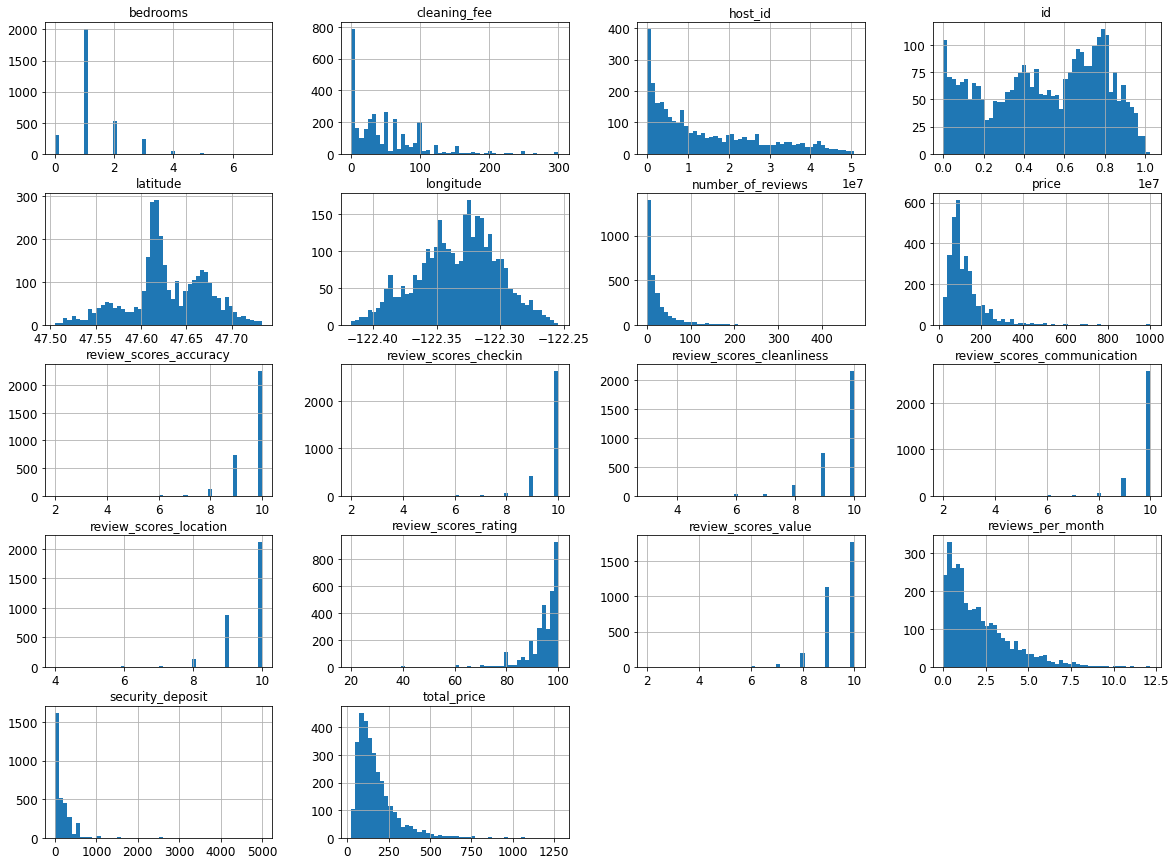

In [30]:
seattle.hist(bins=50, figsize=(20,15))
plt.show()

In [31]:
# X = seattle[['zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 'bedrooms']]
# y = seattle['total_price']

# Split data into training and test data, and fit a linear model
# X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
# lm_model_1 = LinearRegression()

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
# try:
#     lm_model_1.fit(X_train, y_train)
# except:
#     print("Oh no! It doesn't work!!!")

Oh no! It doesn't work!!!


In [9]:
# seattle.dropna(subset=['review_scores_value', 'reviews_per_month', 'review_scores_location', 'review_scores_communication', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_rating' , 'number_of_reviews'], how='any', inplace=True)

# X = seattle[['review_scores_value', 'reviews_per_month', 'review_scores_location', 'review_scores_communication', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_rating' , 'number_of_reviews']]
# y = seattle['total_price']

# Split data into training and test data, and fit a linear model
# X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
# lm_model = LinearRegression()

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
# try:
#    lm_model.fit(X_train, y_train)
#except:
#    print("Oh no! It doesn't work!!!")

In [32]:
#y_test_preds = lm_model.predict(X_test)# Predictions here
#r2_test = r2_score(y_test, y_test_preds) # Rsquared here

# Print r2 to see result
#r2_test

In [46]:
# A function to create test set based on a given test ratio
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[ : test_set_size]
    train_indices = shuffled_indices [test_set_size : ]
    return data.iloc[train_indices], data.iloc[test_indices]

In [47]:
train_set, test_set = split_train_test(seattle, 0.2)
len(train_set)

2537

In [41]:
len(test_set)

634